In [1]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
import os
from mask_functions import rle2mask, mask2rle
from google.cloud import storage

In [2]:
bucket = storage.Client().get_bucket("pneumothorax_chest_x-rays")

In [3]:
blobs = list(bucket.list_blobs(prefix='train/'))

In [4]:
df = pd.read_csv('gs://pneumothorax_chest_x-rays/train-rle.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [5]:
import torch
import torch.utils.data
import collections
from tqdm import tqdm
from PIL import Image

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, blobs, df):
        self.blobs = blobs
        self.df = df
        
        self.image_info = collections.defaultdict(dict)
        
        i = 0
        for blob in tqdm(self.blobs, total= len(self.blobs)):
            file_path = blob.name
            img_id = file_path.split('/')[-1][:-4]
            
            df_temp = self.df.loc[self.df.ImageId == img_id]
            rle = df_temp.iloc[0, 1].strip() # rle is the string in EncodedPixels column
            
            if rle != '-1': #get the train-set
                dcm_path = './dataset/{}.dcm'.format(img_id)
                png_path = './dataset_png/{}.png'.format(img_id)
                
                # if the dcm is not downloaded, download it.
                if not os.path.exists(dcm_path):
                    with open(dcm_path, 'wb') as file_obj:
                        blob.download_to_file(file_obj)  
                # if the png is not created, create it.
                if not os.path.exists(png_path):
                    with open(png_path, 'wb') as file_obj:
                        dcm_data = pydicom.dcmread(dcm_path) #, force=True)  
                        img = dcm_data.pixel_array
                        img_mem = Image.fromarray(img)
                        img_mem.save(file_obj)
                
                self.image_info[i]["image_id"] = img_id
                self.image_info[i]["image_path"] = png_path
                self.image_info[i]["annotations"] = rle
                i += 1
                
            
    def __getitem__(self, idx):
        # images
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")

        # masks
        rle = self.image_info[idx]["annotations"]
        mask_255 = rle2mask(rle, 1024, 1024).T
        
        mask = np.where(mask_255 == 0, 0, 1 )
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        tsr = torchvision.transforms.ToTensor()(img)

        return img, tsr, target, np.uint8(mask_255)
    

    def __len__(self):
        return len(self.image_info)

In [6]:
dataset_test = TorchDataset(blobs, df)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_test)).tolist()

dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

100%|██████████| 10675/10675 [00:17<00:00, 621.52it/s]


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# load the trained parameter
model.load_state_dict(torch.load('./model/model_para.pt'))

# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [9]:
# pick one image from the test set
img, tsr, target, mask = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([tsr.to(device)])

In [10]:
prediction

[{'boxes': tensor([[201.4183, 100.5476, 432.4869, 218.1891],
          [178.7723,  88.9518, 442.5720, 300.3659],
          [148.7390, 119.9361, 440.2418, 498.3129]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9682, 0.3394, 0.1860], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...,

In [11]:
mask_pred = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

In [12]:
np.unique(mask_pred)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
mask_pred255 = np.where(mask_pred <72, 0, 255)

In [14]:
np.unique(mask_pred255)

array([  0, 255])

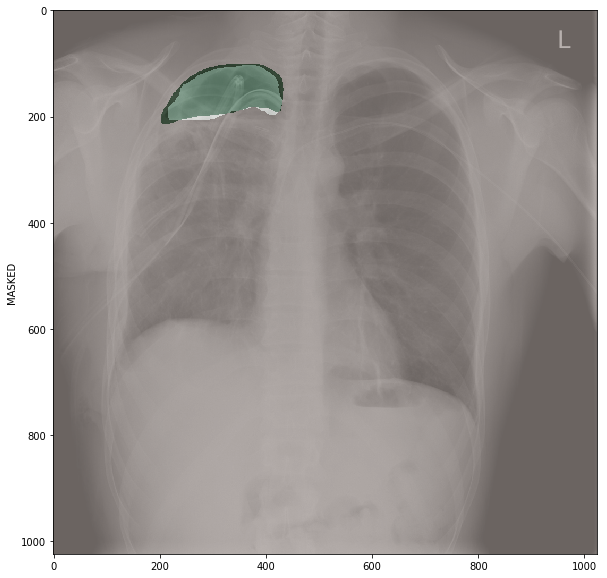

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap=plt.cm.bone)
plt.ylabel('MASKED')
plt.imshow(mask, alpha=0.5, cmap="pink")
plt.imshow(mask_pred255, alpha=0.4, cmap="Greens")

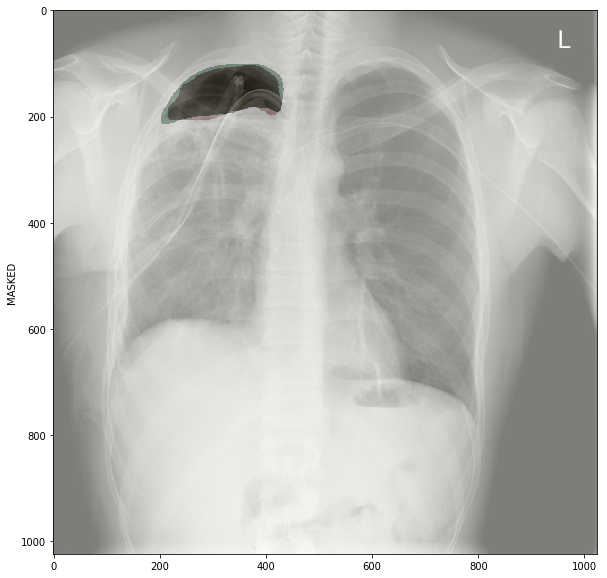

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap=plt.cm.bone)
plt.ylabel('MASKED')
plt.imshow(mask, alpha=0.3, cmap="Reds")
plt.imshow(mask_pred255, alpha=0.3, cmap="Greens")